## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, pairwise_distances

from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KDTree
from sklearn.model_selection import cross_val_score

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        if self.algorithm == 'brute':
            self.X = X
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X, metric='euclidean')
        self.y = y
    
    def predict(self, X):
        X = np.asarray(X)
        if self.algorithm == 'brute':
            pair_dist = cdist(X, self.X, 'euclidean')
            best_idx = pair_dist.argsort(axis=1)[:, :self.n_neighbors]    
        elif self.algorithm == 'kd_tree':
            _, best_idx = self.tree.query(X, k=self.n_neighbors)
        
        nearest_neighbors = best_idx
        i = 0
        predict = np.zeros(X.shape[0])
        for row in nearest_neighbors:
            predict[i] = np.argmax(np.bincount(self.y[row]))
            i += 1
        return predict.astype(int)
        
        k_near_targets = self.y[best_idx]
        
        target_types = np.unique(self.y)[:, None, None]
        
        s = np.sum(target_types == self.y[best_idx], axis=2)
        
        return target_types[np.argmax(s, axis=0), 0, 0]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=5, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.14 ms, sys: 517 µs, total: 1.66 ms
Wall time: 822 µs


KNeighborsClassifier(algorithm='brute')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 8.58 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 6.71 ms, total: 6.71 ms
Wall time: 3.46 ms


array([1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 2.95 ms, sys: 1.34 ms, total: 4.29 ms
Wall time: 1.98 ms


array([1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 2])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 1.8 ms, sys: 811 µs, total: 2.61 ms
Wall time: 1.13 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 286 µs, sys: 130 µs, total: 416 µs
Wall time: 275 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 1.17 ms, sys: 10.7 ms, total: 11.9 ms
Wall time: 5.4 ms


array([2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 2.08 ms, sys: 960 µs, total: 3.04 ms
Wall time: 1.43 ms


array([2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [91]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [92]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [96]:
vectorizer = CountVectorizer(max_df=0.04, min_df=0.005)
X = vectorizer.fit_transform(data).toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [31]:
def cross_validation(n_neighbors, X, y):
    clf = MyKNeighborsClassifier(n_neighbors=n_neighbors, algorithm='kd_tree')
    return cross_val_score(clf, X, target, scoring='accuracy', cv=3)

In [32]:
cross_validation(2, X, target)

array([0.27226935, 0.25934765, 0.26067356])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [35]:
def find_n(X, y):
    t = np.array([cross_validation(i, X, y).mean() for i in range(1, 11)])
    return t

In [36]:
result = find_n(X, target)

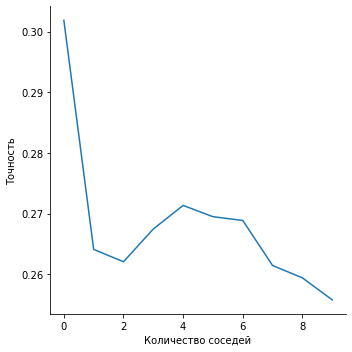

In [40]:
sns.relplot(kind="line", data=result).set(xlabel='Количество соседей', ylabel='Точность')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [42]:
class MyKNeighborsCosineClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        if self.algorithm == 'brute':
            self.X = X
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X, metric='cosine')
        self.y = y
    
    def predict(self, X):
        X = np.asarray(X)
        if self.algorithm == 'brute':
            pair_dist = cdist(X, self.X, 'cosine')
            best_idx = pair_dist.argsort(axis=1)[:, :self.n_neighbors]    
        elif self.algorithm == 'kd_tree':
            _, best_idx = self.tree.query(X, k=self.n_neighbors)
        
        nearest_neighbors = best_idx
        i = 0
        predict = np.zeros(X.shape[0])
        for row in nearest_neighbors:
            predict[i] = np.argmax(np.bincount(self.y[row]))
            i += 1
        return predict.astype(int)
        
        k_near_targets = self.y[best_idx]
        
        target_types = np.unique(self.y)[:, None, None]
        
        s = np.sum(target_types == self.y[best_idx], axis=2)
        
        return target_types[np.argmax(s, axis=0), 0, 0]

In [49]:
def cross_validation_cosine(n_neighbors, X, y):
    clf = MyKNeighborsCosineClassifier(n_neighbors=n_neighbors, algorithm='brute')
    return cross_val_score(clf, X, target, scoring='accuracy', cv=3)

In [50]:
def find_n_cosine(X, y):
    t = np.array([cross_validation_cosine(i, X, y).mean() for i in range(1, 11)])
    return t

In [51]:
result2 = find_n_cosine(X, target)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tf_vectorizer = TfidfVectorizer(max_df = 0.04, min_df = 0.005)
X_tf = tf_vectorizer.fit_transform(data).toarray()

In [58]:
result3 = find_n(X_tf, target)

In [59]:
result4 = find_n_cosine(X_tf, target)

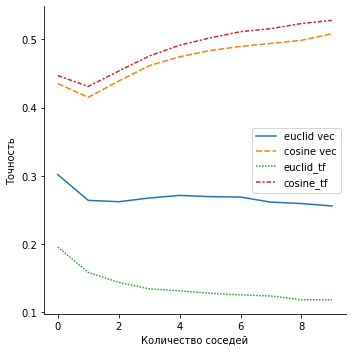

In [85]:
a = sns.relplot(data=t, kind="line", legend=False).set(xlabel='Количество соседей', ylabel='Точность')
plt.legend(labels=['euclid vec', 'cosine vec', 'euclid_tf', 'cosine_tf'])
plt.show(a)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [86]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [94]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [95]:
vectorizer = TfidfVectorizer(max_df=0.04, min_df=0.005)
X_test = vectorizer.fit_transform(data_test).toarray()

In [97]:
clf = MyKNeighborsCosineClassifier(10)
clf.fit(X, target)

In [98]:
print(accuracy_score(target_test, clf.predict(X_test)))

0.6354958458546933


In [99]:
print(result4.max())

0.5280183769289528


Точность отличается, причем в лучшую сторону. Думаю это в пределах погрешности. Вообще на тесте должно быть меньше так как там могут быть неизвестные слова и каки-то новые смысле не учтенные в изначальной выборке. Но нам повезло и точности на тесте получилась больше)